In [29]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats


In [30]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [31]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [32]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


# Background

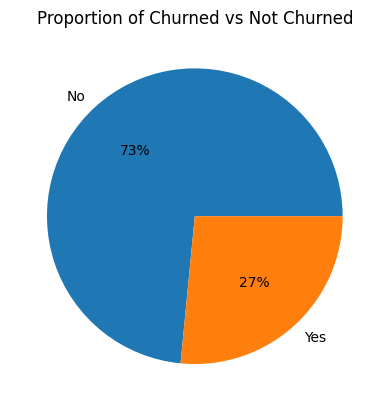

In [33]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

27% of passengers churned from purchasing

In [34]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future gone.

Around `Rp180,870,800.00` stripped out from the company's monthly income.

# EDA

## Distribution

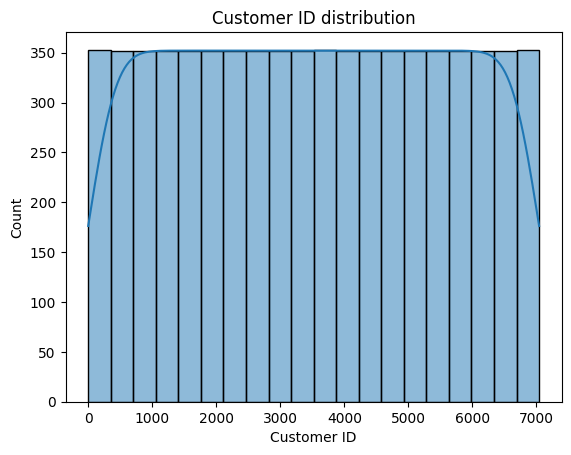

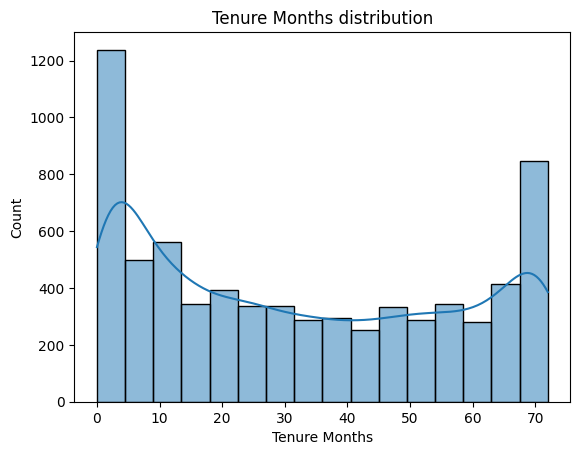

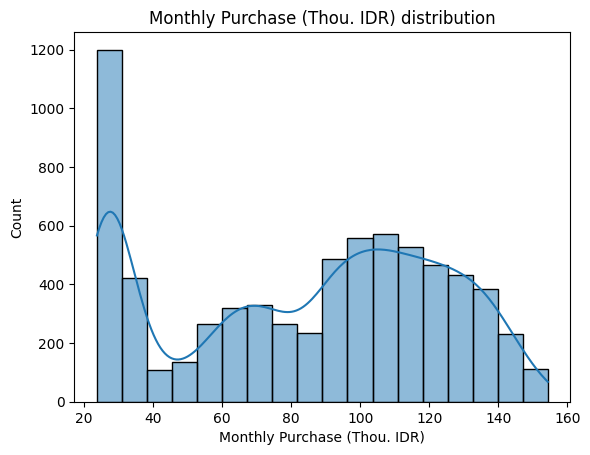

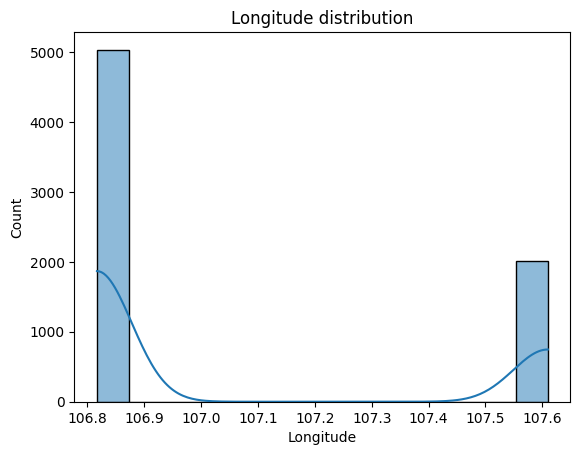

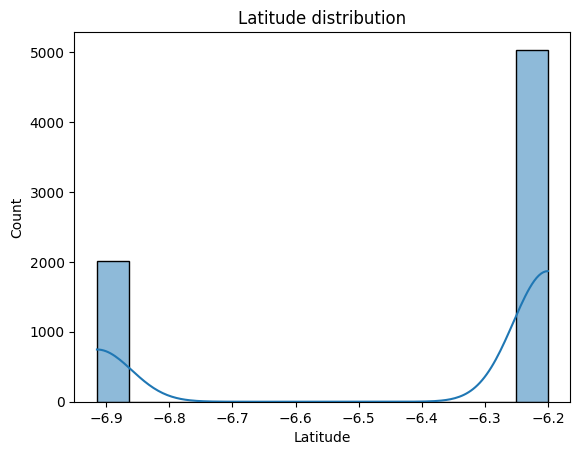

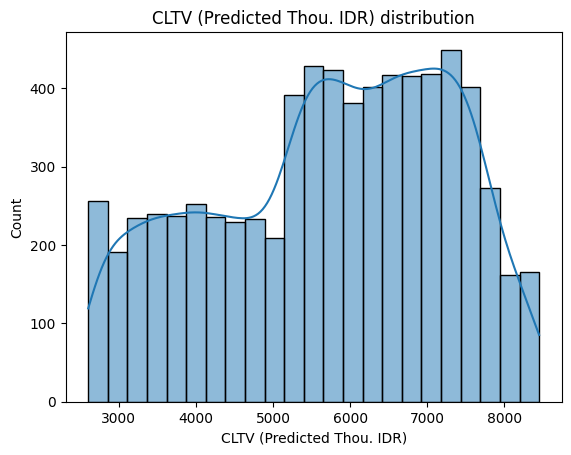

In [35]:
for c in df.select_dtypes(include=[int, float]):
    sns.histplot(df[c], kde=True)
    plt.title(f"{c} distribution")
    plt.show()

### Distribution of Monthly Purchase Below 42

<Axes: xlabel='Monthly Purchase (Thou. IDR)', ylabel='Count'>

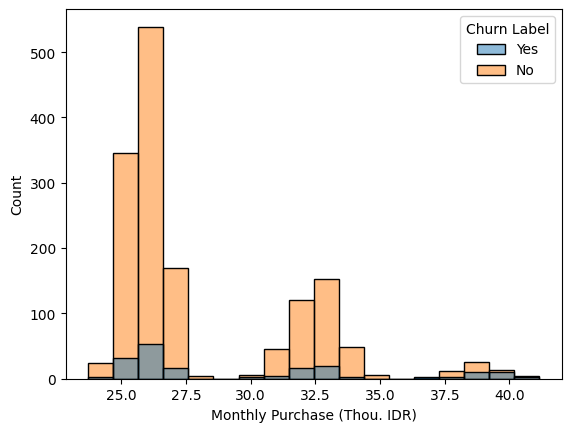

In [36]:
sns.histplot(data=df[df["Monthly Purchase (Thou. IDR)"] <= 42], x="Monthly Purchase (Thou. IDR)", hue="Churn Label")

### Distribution of Monthly Purchase above 42

<Axes: xlabel='Monthly Purchase (Thou. IDR)', ylabel='Count'>

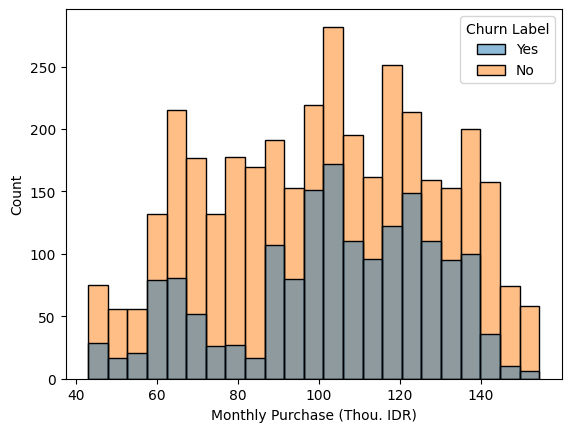

In [37]:
sns.histplot(data=df.loc[df["Monthly Purchase (Thou. IDR)"] > 42], x="Monthly Purchase (Thou. IDR)", hue="Churn Label")

## Device Class

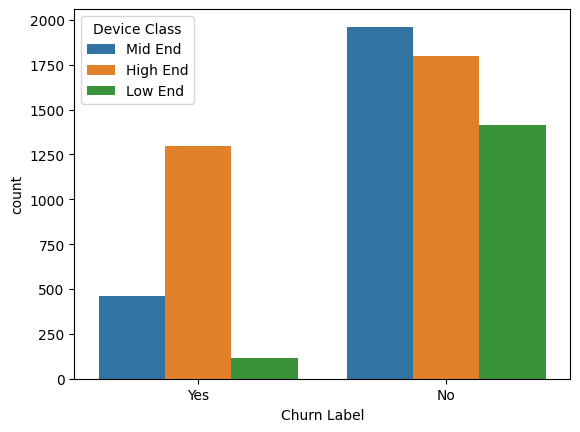

In [38]:
sns.countplot(data=df, x='Churn Label', hue='Device Class')
plt.show()

`~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn

In [39]:
churn_device = df.pivot_table(columns="Device Class", index='Churn Label', values="Customer ID", aggfunc="count", margins=True)
churn_device = churn_device/churn_device.loc['All', :]
churn_device = churn_device.loc[churn_device.index != 'All', churn_device.columns != 'All']
churn_device

Device Class,High End,Low End,Mid End
Churn Label,,,
No,0.581072,0.92595,0.810409
Yes,0.418928,0.07405,0.189591


high end class users have 40% change of churning, 18% are mid end class users, and 7% are from low end class users

## Location

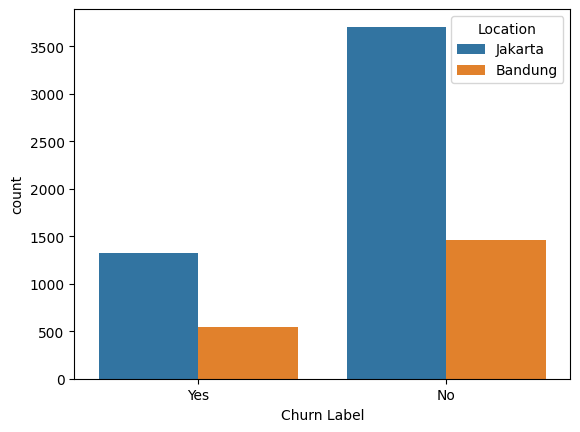

In [40]:
sns.countplot(data=df, x='Churn Label', hue='Location')
plt.show()

`Monthly Purchase (Thou. IDR)` doesn't influence the Churn of customers.

In [41]:
churn_device = df.pivot_table(columns="Location", index='Churn Label', values="Customer ID", aggfunc="count", margins=True)
churn_device = churn_device/churn_device.loc['All', :]
churn_device = churn_device.loc[churn_device.index != 'All', churn_device.columns != 'All']
churn_device

Location,Bandung,Jakarta
Churn Label,,
No,0.728628,0.73703
Yes,0.271372,0.26297


But I think there's no way that location correlates with the churn because the probability are almost the same for users located in Bandung and in Jakarta.

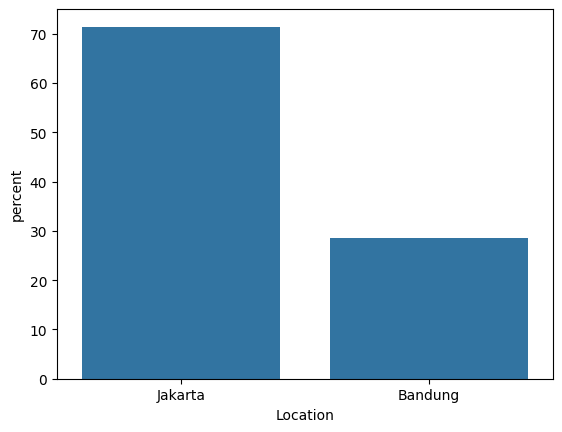

In [14]:
sns.countplot(data=df, x='Location', stat='percent')
plt.show()

It's also not fair to say that people from `Jakarta` has higher change to churn because around 70% are customers from `Jakarta`

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [16]:
# change label of product and app
def preprocess_data(df):
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    # prod_app_map = {
    #     "Yes": 1,
    #     "No": 0,
    #     "No internet service": 0,
    # }
    # df['Games Product'] = df['Games Product'].replace(prod_app_map)
    # df['Music Product'] = df['Music Product'].replace(prod_app_map)
    # df['Education Product'] = df['Education Product'].replace(prod_app_map)
    # df['Video Product'] = df['Video Product'].replace(prod_app_map)
    # df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

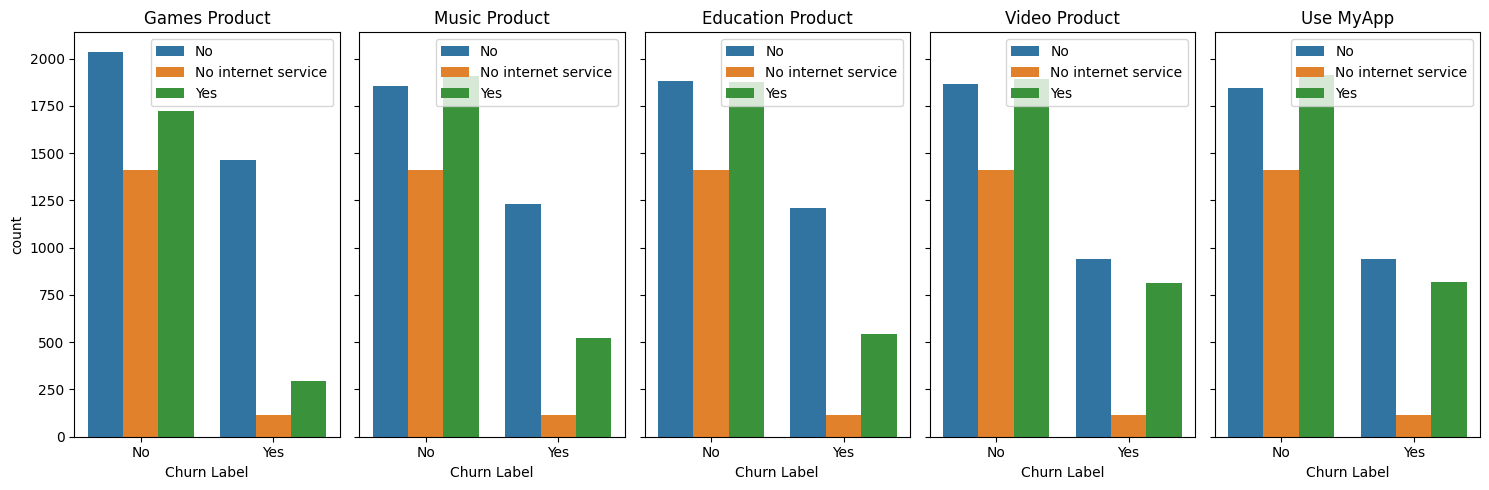

In [25]:
cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(ncols=len(cols), figsize=(15, 5), sharey=True)
for i, c in enumerate(cols):
    sns.countplot(data=df.sort_values(by=[c, 'Churn']), x='Churn Label', hue=c, ax=ax[i])
    ax[i].set_title(c)
    ax[i].legend(
        
    )
fig.tight_layout()

Users who churned they don't use the internet service for accessing those products

## Payment Method

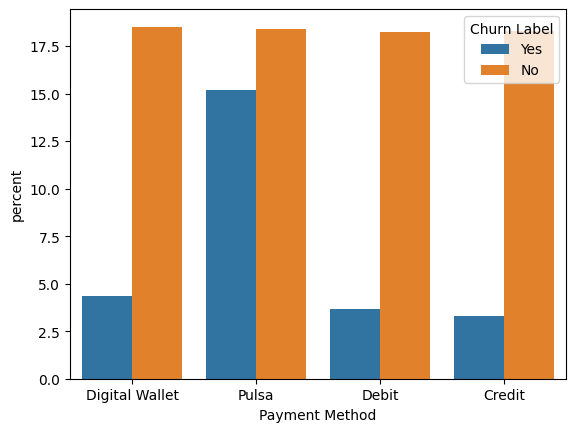

In [26]:
sns.countplot(data=df, x="Payment Method", hue="Churn Label", stat="percent")
plt.show()

In [27]:
churn_payment_method = df.pivot_table(columns="Payment Method", index="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Payment Method,Credit,Debit,Digital Wallet,Pulsa
Churn,,,,
0,0.847569,0.832902,0.808933,0.547146
1,0.152431,0.167098,0.191067,0.452854


If you users buy using pulsa has high change of churn

## Tenure Months

In [28]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


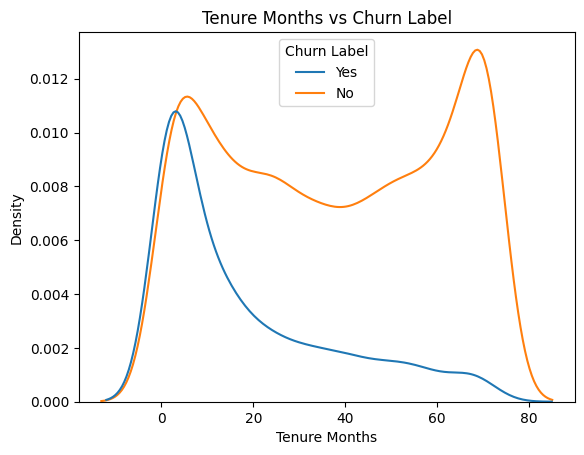

In [29]:
sns.kdeplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

User with low tenure has a high change of churning

## Monthly Purchase

In [30]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

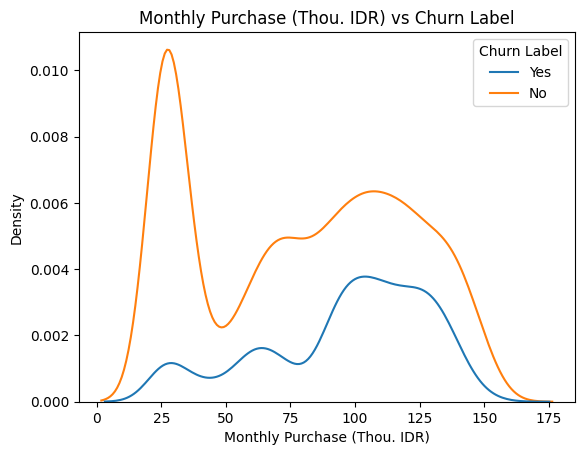

In [31]:
sns.kdeplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 90,000.00 - Rp 140,000.00 a month. The central tendency is there

## CLTV

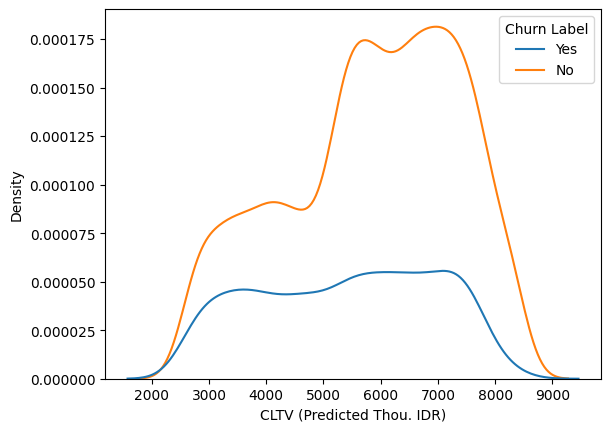

In [32]:
sns.kdeplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature.

## Call Center
Check whether the customer uses the call center service

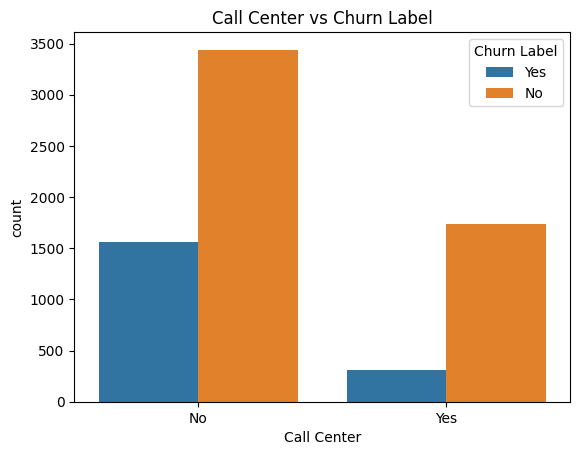

In [33]:
sns.countplot(data=df, x="Call Center", hue="Churn Label")
plt.title("Call Center vs Churn Label")
plt.show()

## Total Purchase

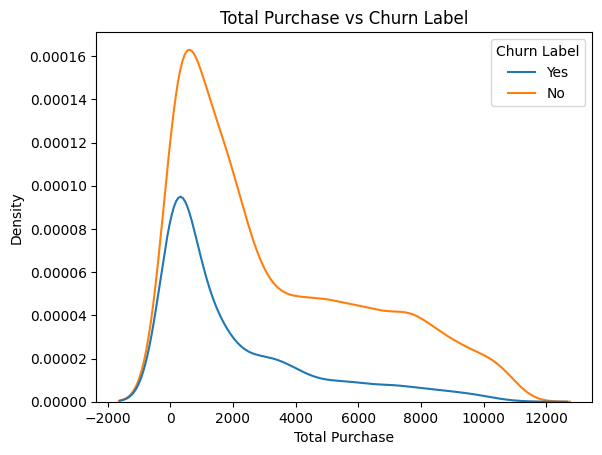

In [34]:
sns.kdeplot(data=df, x="Total Purchase", hue="Churn Label")
plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

## Correlation Map

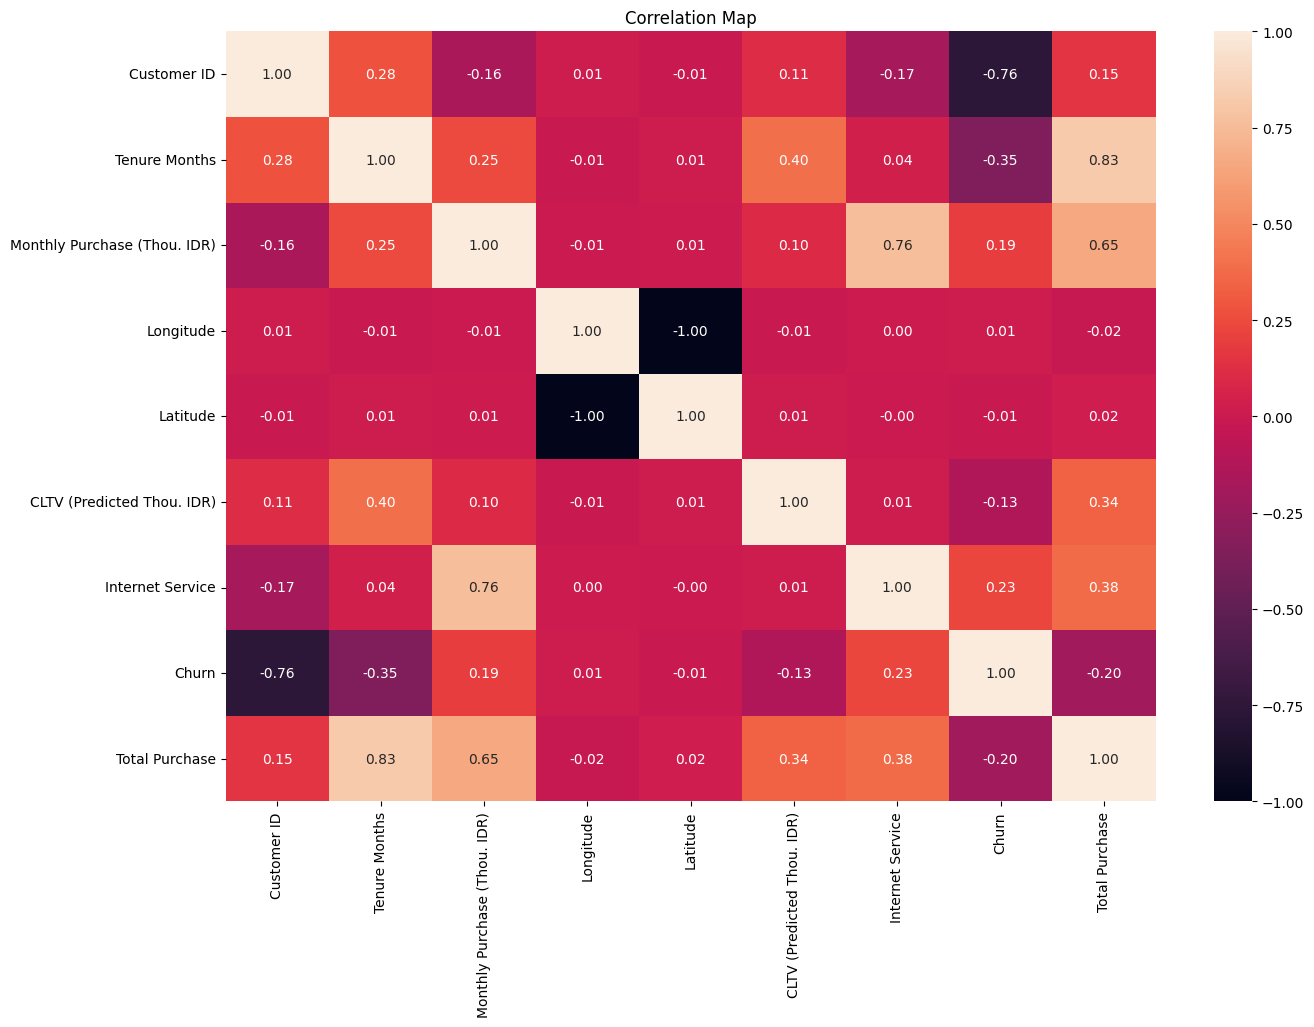

In [35]:
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Modelling

In [64]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Data Preparation

In [82]:
# change label of product and app
df = df_ori.copy()
df['Churn Label'] = df['Churn Label'].replace({"Yes": "1", "No": "0"}).astype(int)
df['Call Center'] = df['Call Center'].replace({"Yes": "1", "No": "0"}).astype(int)

# ordinal encoding
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)

# one hot encoding
df = pd.get_dummies(df, columns=['Payment Method', 'Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp'], dtype=int)

# drop data
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude"])

# split data to train and test
X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val, shuffle=True)

# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [84]:
# Functions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression

# calculate precision, recall, f1 score
def evaluate(y_true, y_pred, y_pred_proba):
    print(f"""
        METRICS
        Precision: {precision_score(y_true, y_pred)}
        Recall: {recall_score(y_true, y_pred)}
        F1 Score: {f1_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title("Confusion Matrix of Logistic Regression (aka. Baseline Model)")
    plt.show()

    # ROC AUC score
    print(f"ROC AUC score: {roc_auc_score(y_true, y_pred)}")

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()
    

def baseline_model(X_train, y_train, X_val, y_val):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(scaler.transform(X_val))
    y_pred_proba = model.predict_proba(scaler.transform(X_val))
    evaluate(y_val, y_pred, y_pred_proba)

    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_val.tolist())
    plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
    plt.show()

## Baseline Model 


        METRICS
        Precision: 0.639751552795031
        Recall: 0.5508021390374331
        F1 Score: 0.5919540229885057
    


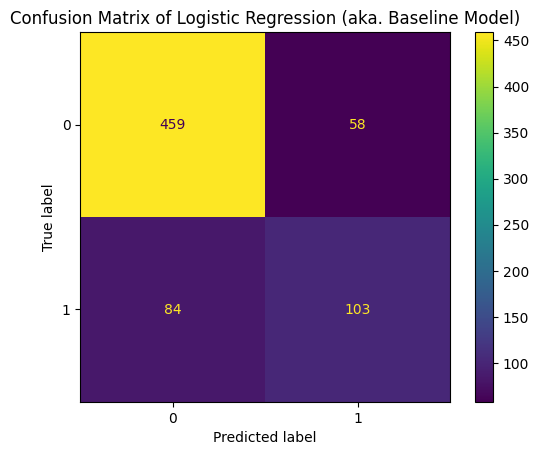

ROC AUC score: 0.7193082261918305


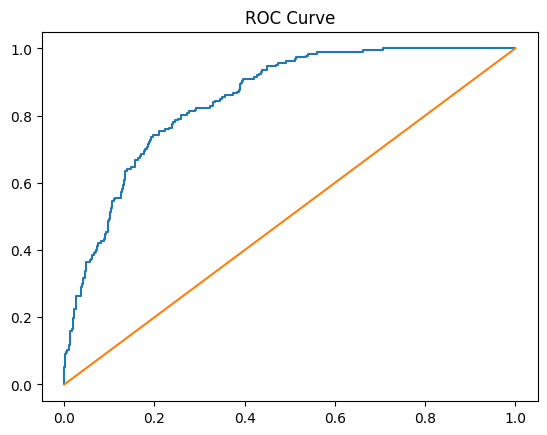

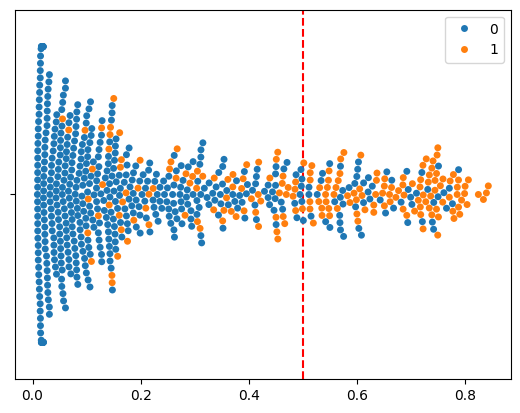

In [86]:
baseline_model(X_train, y_train, X_val, y_val)

1. For churn we would focus on `precision` because we want to identify as much as customer that wanted to churn as possible bcause there's nothing wrong with applying retentioin campaign to customers that don't churn.
2. `ROC AUC score` is also important that because that determines how well our model in **discriminate** customers who churn and not.
3. Swarm plot labels indicate that a lot of actual churn customers don't have a high probability of churn

## Model Improvement

### Perform Oversampling
Oversampling is used to tackle imbalance class problem

#### 1. SMOTE: Synthetic Minority Oversampling Technique

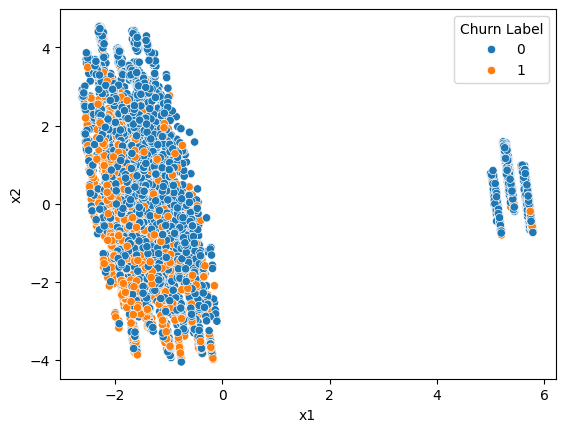

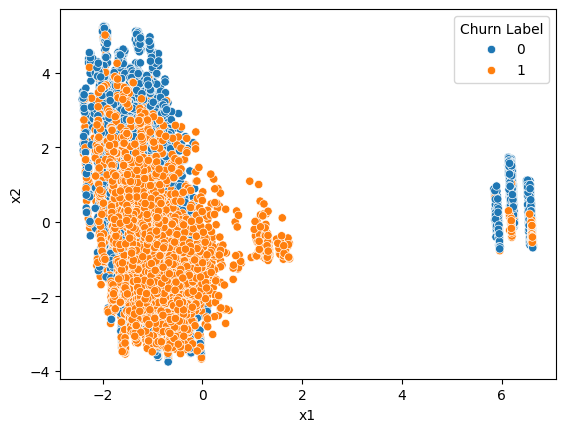

In [106]:
from imblearn.over_sampling import SMOTE

# perform PCA
def plot_pca(X, target):
    # standardize data and applyt pca
    standardize_X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    pca_results = PCA(n_components=2).fit_transform(standardize_X)
    
    # assign result into x1 and x2
    x1, x2 = pca_results[:, 0], pca_results[:, 1]
    
    # plot it
    df_pca = pd.DataFrame({"x1": x1, "x2": x2, "target": target})
    sns.scatterplot(data=df_pca, x="x1", y="x2", hue=target)
    plt.show()

# change label of product and app
df = df_ori.copy()
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})
df['Call Center'] = df['Call Center'].replace({"Yes": 1, "No": 0})

# ordinal encoding
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)

# one hot encoding
df = pd.get_dummies(df, columns=['Payment Method', 'Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp'], dtype=int)

# drop data
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude"])

# split data to train and test
X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val, shuffle=True)

# plot pca before
plot_pca(X_train, y_train)


# Oversample train data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# plot pca after
plot_pca(X_train, y_train)



# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

Test on Baseline Models

In [107]:
# from sklearn.linear_model import LogisticRegression

# model = train(LogisticRegression(random_state=42), X_train, y_train)
# y_pred = model.predict(scaler.transform(X_val))
# y_pred_proba = model.predict_proba(scaler.transform(X_val))
# evaluate(y_val, y_pred, y_pred_proba)

# sns.swarmplot(x=y_pred_proba[:, 1], hue=y_val.tolist())
# plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
# plt.show()

Validate on Other Models

In [18]:
# # # classifiers
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
# from sklearn.metrics import accuracy_score

# models = [
#     LogisticRegression(random_state=42), DecisionTreeClassifier(random_state=42), 
#     RandomForestClassifier(random_state=42), AdaBoostClassifier(random_state=42), 
#     GradientBoostingClassifier(random_state=42), XGBClassifier(random_state=42),
#     CatBoostClassifier(random_state=42), LGBMClassifier(random_state=42)
# ]

# recalls = []
# precisions = []
# f1s = []
# roc_aucs = []
# threshold=0.5

# for model in models:
#     model.fit(X_train, y_train)
#     y_pred_proba = model.predict_proba(scaler.transform(X_val))
#     y_pred = [1 if proba > threshold else 0 for proba in y_pred_proba[:, 1]]
#     recalls.append(recall_score(y_val, y_pred))
#     precisions.append(recall_score(y_val, y_pred))
#     f1s.append(recall_score(y_val, y_pred))
#     roc_aucs.append(roc_auc_score(y_val, y_pred))
    
# df_model = pd.DataFrame(
#     {
#         "Model Name": [model.__class__.__name__ for model in models],
#         "Threshold": [threshold for _ in range(len(models))],
#         "Recall": recalls,
#         "Precisions": precisions,
#         "F1 Score": f1s,
#         "ROC AUC Score": roc_aucs,
#     }
# )

# df_model

### Feature Engineering

In [19]:
# # change label of product and app
# df = df_ori.copy()
# def check_internet_service(row): 
#     if row['Games Product'] == "No internet service"\
#         and row['Music Product'] == "No internet service"\
#         and row['Education Product'] == "No internet service"\
#         and row['Video Product'] == "No internet service"\
#         and row['Use MyApp'] == "No internet service":
#         return 0
#     else: return 1

# # generate new features    
# df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)

# # replace values
# df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})
# df['Call Center'] = df['Call Center'].replace({"Yes": 1, "No": 0})

# # ordinal encoding
# device_class_map = {
#     "High End": 3,
#     "Mid End": 2,
#     "Low End": 1
# }
# df["Device Class"] = df["Device Class"].replace(device_class_map)

# # one hot encoding
# df = pd.get_dummies(df, columns=['Payment Method', 'Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp'], dtype=int)

# # drop data
# df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude"])

# # split data to train and test
# X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

# # scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)

### Different Model

In [20]:
# # classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

models = [
    LogisticRegression(random_state=42), DecisionTreeClassifier(random_state=42), 
    RandomForestClassifier(random_state=42), AdaBoostClassifier(random_state=42), 
    GradientBoostingClassifier(random_state=42), XGBClassifier(random_state=42),
    CatBoostClassifier(random_state=42), LGBMClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []
threshold=0.5

for model in models:
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(scaler.transform(X_val))
    y_pred = [1 if proba > threshold else 0 for proba in y_pred_proba[:, 1]]
    recalls.append(recall_score(y_val, y_pred))
    precisions.append(recall_score(y_val, y_pred))
    f1s.append(recall_score(y_val, y_pred))
    roc_aucs.append(roc_auc_score(y_val, y_pred))
    
df_model = pd.DataFrame(
    {
        "Model Name": [model.__class__.__name__ for model in models],
        "Threshold": [threshold for _ in range(len(models))],
        "Recall": recalls,
        "Precisions": precisions,
        "F1 Score": f1s,
        "ROC AUC Score": roc_aucs,
    }
)

df_model

Learning rate set to 0.025403
0:	learn: 0.6734773	total: 5.34ms	remaining: 5.33s
1:	learn: 0.6593542	total: 9.21ms	remaining: 4.59s
2:	learn: 0.6424541	total: 13.2ms	remaining: 4.37s
3:	learn: 0.6263630	total: 16.5ms	remaining: 4.1s
4:	learn: 0.6151459	total: 19.9ms	remaining: 3.97s
5:	learn: 0.6044277	total: 23.6ms	remaining: 3.91s
6:	learn: 0.5914927	total: 27.9ms	remaining: 3.96s
7:	learn: 0.5822513	total: 32.2ms	remaining: 3.99s
8:	learn: 0.5705845	total: 35.8ms	remaining: 3.94s
9:	learn: 0.5620815	total: 40.6ms	remaining: 4.02s
10:	learn: 0.5516359	total: 44.6ms	remaining: 4.01s
11:	learn: 0.5456069	total: 48.2ms	remaining: 3.97s
12:	learn: 0.5385370	total: 51.8ms	remaining: 3.93s
13:	learn: 0.5235489	total: 55.7ms	remaining: 3.92s
14:	learn: 0.5095820	total: 60.2ms	remaining: 3.95s
15:	learn: 0.5045226	total: 64.6ms	remaining: 3.98s
16:	learn: 0.4992471	total: 68.4ms	remaining: 3.96s
17:	learn: 0.4942093	total: 72.7ms	remaining: 3.96s
18:	learn: 0.4857143	total: 77.8ms	remaining:

,Model Name,Threshold,Recall,Precisions,F1 Score,ROC AUC Score
0,LogisticRegression,0.5,0.577540,0.577540,0.577540,0.723006
1,DecisionTreeClassifier,0.5,0.524064,0.524064,0.524064,0.650814
2,RandomForestClassifier,0.5,0.566845,0.566845,0.566845,0.707020
3,AdaBoostClassifier,0.5,0.673797,0.673797,0.673797,0.748891
4,GradientBoostingClassifier,0.5,0.620321,0.620321,0.620321,0.731824
5,XGBClassifier,0.5,0.518717,0.518717,0.518717,0.683923
6,CatBoostClassifier,0.5,0.588235,0.588235,0.588235,0.720617
7,LGBMClassifier,0.5,0.561497,0.561497,0.561497,0.708215
